# Descripción del proyecto

El servicio de telefonía virtual CallMeMaybe está desarrollando una nueva función que brindará a los supervisores y las supervisores información sobre los operadores menos eficaces. Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes. Además, si se supone que un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de ineficacia.


# Descripción de los datos


Los datasets contienen información sobre el uso del servicio de telefonía virtual CallMeMaybe. Sus clientes son organizaciones que necesitan distribuir gran cantidad de llamadas entrantes entre varios operadores, o realizar llamadas salientes a través de sus operadores. Los operadores también pueden realizar llamadas internas para comunicarse entre ellos. Estas llamadas se realizan a través de la red de CallMeMaybe.

El dataset comprimido `telecom_dataset_us.csv` contiene las siguientes columnas:

- `user_id`: ID de la cuenta de cliente
- `date`: fecha en la que se recuperaron las estadísticas
- `direction`: "dirección" de llamada (`out` para saliente, `in` para entrante)
- `internal`: si la llamada fue interna (entre los operadores de un cliente o clienta)
- `operator_id`: identificador del operador
- `is_missed_call`: si fue una llamada perdida
- `calls_count`: número de llamadas
- `call_duration`: duración de la llamada (sin incluir el tiempo de espera)
- `total_call_duration`: duración de la llamada (incluido el tiempo de espera)



El conjunto de datos `telecom_clients_us.csv` tiene las siguientes columnas:

- `user_id`: ID de usuario/a
- `tariff_plan`: tarifa actual de la clientela
- `date_start`: fecha de registro de la clientela

# Inicialización

In [1]:
#importamos librerias
import pandas as pd
import numpy as np
import seaborn as sns
import os
import time
import pytz
import pandas.testing as tm
import scipy.cluster.hierarchy as sch

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import ttest_ind
from scipy import stats as st

In [2]:
#Cargamos los archivos de datos
try:
  clients = pd.read_csv('/datasets/telecom_clients_us.csv')
except:
  clients = pd.read_csv('/content/telecom_clients_us.csv')

try:
  calls = pd.read_csv('/datasets/telecom_dataset_us.csv')
except:
  calls = pd.read_csv('/content/telecom_dataset_us.csv')

In [3]:
# previsualizar los datos cargados
clients.info()

# devolver las n filas superiores del dataframe
clients.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16
5,167764,A,2019-09-30
6,167050,A,2019-08-29
7,168252,A,2019-10-17
8,168495,A,2019-10-28
9,167879,A,2019-10-03


* Es necesario cambiar el tipo de datos de date_start a datetime.
* No parece haber valores ausentes.

In [4]:
# previsualizar los datos cargados
calls.info()

# devolver las n filas superiores del dataframe
calls.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25
5,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,False,2,3,29
6,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35
8,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
9,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62


*   Es necesario cambiar al tipo de datos correcto para las columnas date, internal
* Tenemos valores ausentes en operator_id



# Estudiar y preparar los datos

## Cambiar tipo de datos

In [5]:
# cambiar a datetime, asegurandonos que ambas columnas de fechas usen el mismo formato
clients['date_start'] = pd.to_datetime(clients['date_start'])
calls['date'] = pd.to_datetime(calls['date']).dt.tz_convert(None)

# cambiar a bool
calls['internal'] = calls['internal'].astype('bool')

## Duplicados

In [6]:
#Validando duplicados en archivo de clientes
clients[clients.duplicated()]

,user_id,tariff_plan,date_start


In [7]:
#Validando duplicados en archivo de llamadas
calls[calls.duplicated()]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
8,166377,2019-08-04 21:00:00,out,False,880020.0,True,8,0,50
28,166377,2019-08-11 21:00:00,in,False,NaN,True,2,0,34
44,166377,2019-08-13 21:00:00,out,False,880026.0,False,10,1567,1654
45,166377,2019-08-13 21:00:00,in,False,NaN,True,1,0,3
51,166377,2019-08-14 21:00:00,out,False,880026.0,False,11,1413,1473
...,...,...,...,...,...,...,...,...,...
53869,168601,2019-11-24 21:00:00,in,False,952914.0,False,7,1229,1282
53874,168601,2019-11-25 21:00:00,in,False,952914.0,False,4,539,562
53875,168601,2019-11-25 21:00:00,in,False,NaN,True,3,0,35
53885,168603,2019-11-19 21:00:00,out,False,959118.0,True,3,0,89


In [8]:
print((len(calls[calls.duplicated()]) / len(calls))*100)

9.090571778412675


En el archivo de llamadas tenemos 4900 duplicados, lo que equivale al 9% de los datos. Es muy extraño que todas las columnas tengan los mismos valores (especialmente la duración). Estudiemoslos más a profundidad para ver si ha sido un error localizado, ya sea en rangos de tiempo o para un dato en especifico.

In [9]:
#Estudiemos el rango de tiempo en que se dieron los duplicados
calls[calls.duplicated()]['date'].describe(datetime_is_numeric=True)

count                             4900
mean     2019-10-22 22:14:03.428571392
min                2019-08-02 21:00:00
25%                2019-10-03 21:00:00
50%                2019-10-27 21:00:00
75%                2019-11-13 21:00:00
max                2019-11-27 21:00:00
Name: date, dtype: object

In [10]:
calls['date'].describe(datetime_is_numeric=True)

count                            53902
mean     2019-10-22 22:00:32.191755520
min                2019-08-01 21:00:00
25%                2019-10-03 21:00:00
50%                2019-10-27 21:00:00
75%                2019-11-13 21:00:00
max                2019-11-27 21:00:00
Name: date, dtype: object

No pareciera que los duplicados se hayan generado en un rango de tiempo localizado. Evaluemos si se centran en algún dato en especifico

In [11]:
#evaluando si los duplicados se centran en un dato especifico
for i in calls[calls.duplicated()].columns:
    print(i, ':', calls[calls.duplicated()][i].nunique())

user_id : 269
date : 115
direction : 2
internal : 2
operator_id : 776
is_missed_call : 2
calls_count : 178
call_duration : 1547
total_call_duration : 1820


In [12]:
for i in calls.columns:
    print(i, ':', calls[i].nunique())

user_id : 307
date : 119
direction : 2
internal : 2
operator_id : 1092
is_missed_call : 2
calls_count : 502
call_duration : 5373
total_call_duration : 6040


Podemos decir que los duplicados son un error general, no se centra en un rango de fechas localizado ni en una caracteristica especifica. Parece que hay un problema técnico con la extracción de datos a la base de datos o algo parecido. Decidimos eliminar los duplicados.

In [13]:
calls = calls.drop_duplicates().reset_index(drop=True)
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49002 entries, 0 to 49001
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              49002 non-null  int64         
 1   date                 49002 non-null  datetime64[ns]
 2   direction            49002 non-null  object        
 3   internal             49002 non-null  bool          
 4   operator_id          41546 non-null  float64       
 5   is_missed_call       49002 non-null  bool          
 6   calls_count          49002 non-null  int64         
 7   call_duration        49002 non-null  int64         
 8   total_call_duration  49002 non-null  int64         
dtypes: bool(2), datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 2.7+ MB


## Valores ausentes

In [14]:
#buscando valores ausentes en clients
clients[clients.isnull().any(axis=1)]

,user_id,tariff_plan,date_start


In [15]:
#buscando valores ausentes en clients
calls[calls.isnull().any(axis=1)]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-03 21:00:00,in,False,NaN,True,2,0,4
7,166377,2019-08-04 21:00:00,in,False,NaN,True,6,0,35
8,166377,2019-08-05 21:00:00,in,False,NaN,True,4,0,62
16,166377,2019-08-06 21:00:00,in,False,NaN,True,2,0,24
26,166377,2019-08-11 21:00:00,in,False,NaN,True,2,0,34
...,...,...,...,...,...,...,...,...,...
48978,168601,2019-11-26 21:00:00,in,False,NaN,True,2,0,39
48982,168601,2019-11-27 21:00:00,in,False,NaN,True,1,0,19
48990,168603,2019-11-27 21:00:00,in,False,NaN,True,1,0,30
48994,168606,2019-11-07 21:00:00,in,False,NaN,True,6,0,121


In [16]:
#evaluando valores ausentes en operator_id
print("Hay", len(calls[calls.operator_id.isnull()]),"valores ausentes en operator_id")
print("Lo que equivale al",(len(calls[calls.operator_id.isnull()]) / len(calls))*100,"% de los datos")

Hay 7456 valores ausentes en operator_id
Lo que equivale al 15.215705481408923 % de los datos


El 15% de los datos no tiene operator_id asignado. Dado que nuestro objetivo es identificar los operadores ineficientes (según su operator_id), esta columna es crucial para nuestra investigación. En primera instancia evaluaremos si hay algún patron de estos datos ausentes que nos pueda ayudar a recuperar el operator_id, de lo contrario sería necesario eliminarlos.

In [17]:
#separemos los datos ausentes en un dataframe
op_null=calls.query('operator_id.isnull()')

#y lo unimos a los datos de clientes
op_null=op_null.merge(clients, on='user_id', how='left')
op_null.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
0,166377,2019-08-03 21:00:00,in,False,NaN,True,2,0,4,B,2019-08-01
1,166377,2019-08-04 21:00:00,in,False,NaN,True,6,0,35,B,2019-08-01
2,166377,2019-08-05 21:00:00,in,False,NaN,True,4,0,62,B,2019-08-01
3,166377,2019-08-06 21:00:00,in,False,NaN,True,2,0,24,B,2019-08-01
4,166377,2019-08-11 21:00:00,in,False,NaN,True,2,0,34,B,2019-08-01


In [18]:
#evaluando usuarios unicos de los datos ausentes
op_null.user_id.nunique()

305

In [19]:
#Evaluando planes de los datos ausentes
op_null.groupby(['tariff_plan']).agg({'user_id':'nunique'}).reset_index()

,tariff_plan,user_id
0,A,33
1,B,112
2,C,160


In [20]:
#evaluando si los datos ausentes son llamadas perdidas
op_null.groupby(['is_missed_call']).size()

is_missed_call
False     113
True     7343
dtype: int64

In [21]:
#evaluando si los datos ausentes son llamadas internas
op_null.groupby(['internal']).size()

internal
False    7078
True      378
dtype: int64

In [22]:
#evaluando la dirección de los datos ausentes
op_null.groupby(['direction']).size()

direction
in     7270
out     186
dtype: int64

No parece que los valores ausentes de operator_id estén determinados por algún otro dato y no podemos recuperar esta información por lo que tendremos que eliminarlos.

In [23]:
#eliminando valores ausentes
calls.dropna(inplace=True)
calls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41546 entries, 1 to 49000
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              41546 non-null  int64         
 1   date                 41546 non-null  datetime64[ns]
 2   direction            41546 non-null  object        
 3   internal             41546 non-null  bool          
 4   operator_id          41546 non-null  float64       
 5   is_missed_call       41546 non-null  bool          
 6   calls_count          41546 non-null  int64         
 7   call_duration        41546 non-null  int64         
 8   total_call_duration  41546 non-null  int64         
dtypes: bool(2), datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 2.6+ MB


In [24]:
#cambiando tipo de datos de operator_id a int
calls['operator_id'] = calls['operator_id'].astype(int)

## Unificar datos

Unirmemos nuestros datos en un solo dataframe.

In [25]:
#Uniendo dataframe de llamadas con clientes
merged_data=calls.merge(clients, on='user_id', how='left')
merged_data.head(1)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
0,166377,2019-08-04 21:00:00,out,True,880022,True,3,0,5,B,2019-08-01


## Coherencia de los datos

Evaluemos que nuestra información tenga lógica.

### Comprobar que no existen registros de llamadas realizadas antes que la fecha de registro

In [26]:
merged_data[merged_data['date_start'] >= merged_data['date']].shape[0]

106

Se encontraron 106 registros donde la fecha de la llamada es anterior a la fecha de registro del cliente. Estos registros no son coherentes y deberían ser eliminados.

In [27]:
#eliminando registros no coherentes
merged_data = merged_data[merged_data['date'] >= merged_data['date_start']]

### Comprobar que no existen llamadas con duración total menor que duración de la llamada

In [28]:
merged_data[merged_data['total_call_duration'] < merged_data['call_duration']].shape[0]

0

No se encontraron registros con duraciones incoherentes, lo cual es una buena señal.

### Comprobar si hay clientes con más de una tarifa asignada

In [29]:
tariffs = clients.groupby('user_id')['tariff_plan'].count()
tariffs[tariffs>1].shape[0]

0

No se encontraron usuarios con múltiples tarifas asignadas, lo cual es consistente.

### Comprobar llamadas con duración 0 y decidir que hacer con ellas

In [30]:
((merged_data['call_duration']==0) | (merged_data['total_call_duration']==0)).sum()

13784

In [31]:
merged_data[(merged_data['call_duration']==0) | (merged_data['total_call_duration']==0)].head(5)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
0,166377,2019-08-04 21:00:00,out,True,880022,True,3,0,5,B,2019-08-01
1,166377,2019-08-04 21:00:00,out,True,880020,True,1,0,1,B,2019-08-01
3,166377,2019-08-04 21:00:00,out,False,880022,True,3,0,25,B,2019-08-01
5,166377,2019-08-04 21:00:00,out,False,880020,True,8,0,50,B,2019-08-01
6,166377,2019-08-05 21:00:00,out,False,881278,True,3,0,29,B,2019-08-01


Pareciera que las llamadas con duración 0 son las llamadas perdidas.

In [32]:
zduration_calls = merged_data[(merged_data['call_duration']==0) | (merged_data['total_call_duration']==0)]
zduration_missed_calls = zduration_calls[zduration_calls['is_missed_call'] == True]

# Porcentaje de llamadas de duración 0 que son llamadas perdidas
percentage_zero_duration_missed = (zduration_missed_calls.shape[0] / zduration_calls.shape[0]) * 100
percentage_zero_duration_missed

99.87666860127685

De las llamadas que tienen una duración de 0 segundos, aproximadamente el
99.88% son llamadas perdidas. Esta alta correlación sugiere que las llamadas con una duración de 0 segundos son, en su gran mayoría, llamadas que no fueron atendidas. Dado este hallazgo, es razonable teorizar que las llamadas con una duración de 0 segundos se registran de esa manera porque son llamadas que no fueron contestadas, y por ende, no tienen una duración asociada.

Hay un pequeño porcentaje de llamadas de 0 segundos que no están marcadas como perdidas, posiblemente esto es porque  la duración se registra como segundos y si la llamada por algún error dura solo algunos milisegundos se registrará como cero y no como llamada perdida, por lo que consideraremos que estas llamadas son llamadas perdidas.

In [33]:
# Marcar todas las llamadas con duración de 0 segundos como llamadas perdidas
merged_data.loc[merged_data['call_duration'] == 0, 'is_missed_call'] = True

- Modificamos los tipos de datos de las columnas relacionadas con fechas a datetime. También aseguramos que las columnas booleanas estuvieran correctamente tipificadas.

- Detectamos y eliminamos 4.900 registros duplicados en el dataset telecom_data.

- Encontramos 7.456 registros en telecom_data sin un operator_id asignado.

- Fusión de Dataframes: Fusionamos telecom_data con telecom_clients usando user_id para tener toda la información en un solo dataframe.

- Coherencia de Datos:

  - Identificamos 106 registros donde la fecha de la llamada es anterior a la fecha de registro del cliente, lo que es incoherente.
  - Verificamos que todas las llamadas tienen una duración coherente, es decir, que la duración total no es menor que la duración de la llamada en sí.
  - Confirmamos que no hay clientes con múltiples tarifas asignadas.
  - Determinamos que casi el 100% de las llamadas con una duración de 0 segundos son llamadas perdidas.

Este paso nos permitió entender mejor la estructura y calidad de nuestros datos. A través del proceso, pudimos identificar y corregir problemas como registros duplicados, valores ausentes y registros incoherentes. En particular, descubrimos que las llamadas con una duración de 0 segundos son, en su mayoría, llamadas no atendidas, lo que nos proporciona información valiosa sobre la naturaleza de estas llamadas. Estos insights nos permitirán realizar análisis más precisos en las siguientes etapas del proyecto.

# Enriquecer los datos

Enriqueceremos los datos con columnas que no serán utiles para nuestro analisis posterior añadiendo columnas de fecha truncada (sin contador de hora), mes y tiempo de espera.

In [34]:
# Agregar columnas de fecha truncada y mes
merged_data['date_trunc'] = merged_data['date'].dt.date
merged_data['month'] = merged_data['date'].dt.month
#Agregar columna de tiempo de espera
merged_data['waiting_time'] = merged_data['total_call_duration'] - merged_data['call_duration']

<ipython-input-34-745c2e11bd25>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data['date_trunc'] = merged_data['date'].dt.date
<ipython-input-34-745c2e11bd25>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data['month'] = merged_data['date'].dt.month
<ipython-input-34-745c2e11bd25>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

Agregamos 3 columnas:
- 'date_trunc': fecha truncada de la llamada.
- 'month': mes de la llamada.
- 'waiting_time' : tiempo de espera de la llamada.

# Analisis exploratorio de los datos (EDA)

Exploremos nuestros datos más a profundidad

## Calcular la cantidad de clientes.

In [35]:
# Calcular el número de Clientes
clients['user_id'].nunique()

732

In [36]:
# Calcular el número de clientes en el dataset a trabajar
merged_data['user_id'].nunique()

290

El número total de clientes del servicio es 732, pero consideraremos solo 290 de ellos ya que son de los cuales tenemos información util para el análisis.

## Calcular la cantidad de operadores

In [37]:
# Calcular el número de Clientes
calls['operator_id'].nunique()

1092

In [38]:
# Calcular el número de clientes en el dataset a trabajar
merged_data['operator_id'].nunique()

1088

El número total de operadores del servicio es 1092, pero consideraremos solo 1088 de ellos ya que son de los cuales tenemos información util para el análisis.

## Operadores por cliente

Calcularemos la cantidad de operadores por cliente y obtener el TOP 10 de clientes con más operadores.

In [39]:
# Calcular el número de operadores únicos por cliente
operators_per_client = merged_data.groupby('user_id')['operator_id'].nunique().sort_values(ascending=False)

# Obtener el TOP10 de clientes con más operadores
operators_per_client.head(10)

user_id
168187    50
167626    48
167497    30
168252    28
168062    27
168361    25
166680    21
166520    18
166658    17
166916    16
Name: operator_id, dtype: int64

In [40]:
operators_per_client.describe()

count    290.000000
mean       3.751724
std        5.684960
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       50.000000
Name: operator_id, dtype: float64

- Podemos ver que hay clientes a los cuales se les ha asignado hasta 50 operadores.
- El 50% de los clientes no tienen más de 2 operadores.
- El 75% de los clientes no tiene más de 4 operadores.

## Distribución de la duración de las llamadas

Visualicemos la distribución de la duración de las llamadas sin considerar las llamadas perdidas (duración 0).

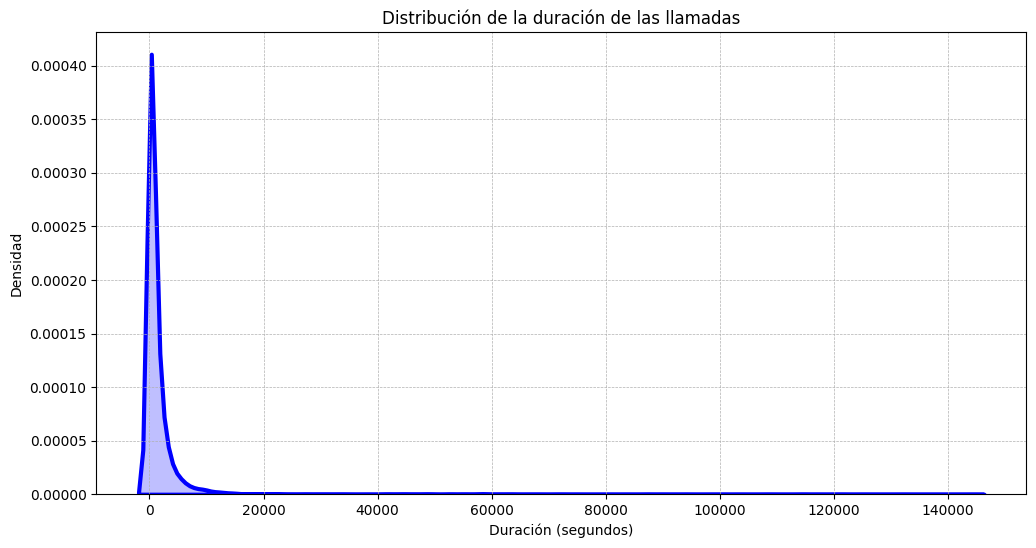

In [41]:
# Filtrar las llamadas no perdidas
non_missed_calls = merged_data[merged_data['is_missed_call'] == False]

# Estudiar la distribución de la duración de las llamadas no perdidas
plt.figure(figsize=(12, 6))
sns.kdeplot(non_missed_calls['call_duration'], fill=True, color='blue', linewidth=3)
plt.title('Distribución de la duración de las llamadas')
plt.xlabel('Duración (segundos)')
plt.ylabel('Densidad')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

La gráfica muestra la distribución de la duración de las llamadas, excluyendo las llamadas perdidas. Observamos que la mayoría de las llamadas atendidas tienen una duración relativamente corta, pero también hay algunas llamadas que duran más, extendiéndose hasta varios miles de segundos

In [42]:
# estadisticas descriptivas de la duración de llamadas
merged_data['call_duration'].describe()

count     41440.000000
mean       1011.712934
std        4068.983352
min           0.000000
25%           0.000000
50%         106.000000
75%         772.250000
max      144395.000000
Name: call_duration, dtype: float64

In [43]:
# estadisticas descriptivas de la duración de llamadas sin considerar las llamadas perdidas
merged_data[merged_data['call_duration']>0]['call_duration'].describe()

count     27656.000000
mean       1515.959792
std        4903.514035
min           1.000000
25%         106.000000
50%         434.000000
75%        1399.000000
max      144395.000000
Name: call_duration, dtype: float64

- Al menos el 25% de las llamadas tienen una duración de 0.
- La duración media de las llamadas (entre las llamadas no perdidas) es de ~7 minutos, mientras que el valor medio es de ~25 minutos con una desviación estándar de ~1 hora y 20 minutos, lo que genera una cola pesada hacia la derecha.
- Nuestros números parecen razonables, pero tenemos llamadas que duraron hasta 40 horas, lo que no parece muy lógico.

## Distribución de llamadas en el tiempo

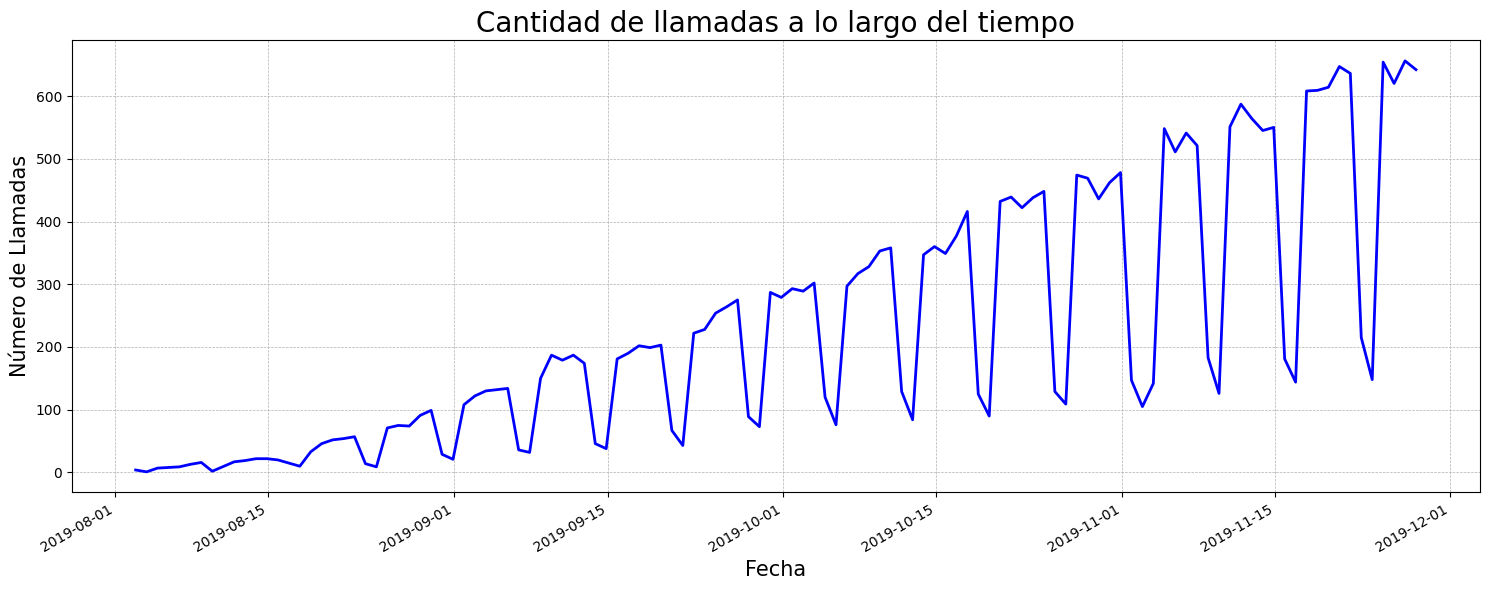

In [44]:
# Graficar el número de llamadas a lo largo del tiempo
plt.figure(figsize=(15, 6))

# Agrupar por fecha y contar el número de llamadas
calls_per_day = non_missed_calls.groupby('date').size()

calls_per_day.plot(lw=2, color='blue')

plt.title('Cantidad de llamadas a lo largo del tiempo', fontsize=20)
plt.xlabel('Fecha', fontsize=15)
plt.ylabel('Número de Llamadas', fontsize=15)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

- Hay una tendencia general de aumento en el número de llamadas a medida que avanzamos en el tiempo. Esto podría indicar un crecimiento en el uso del servicio de telefonía o un aumento en el número de usuarios/clientes.

- Existen fluctuaciones notables en el número de llamadas, lo que podría deberse a factores estacionales, días laborables vs. fines de semana, o eventos específicos que generan un volumen alto o bajo de llamadas.

- Hay varios picos visibles en la gráfica, que representan días con un número inusualmente alto de llamadas. Estos podrían ser días específicos de la semana, días festivos o eventos especiales.

## Proporción de llamadas internas vs externas

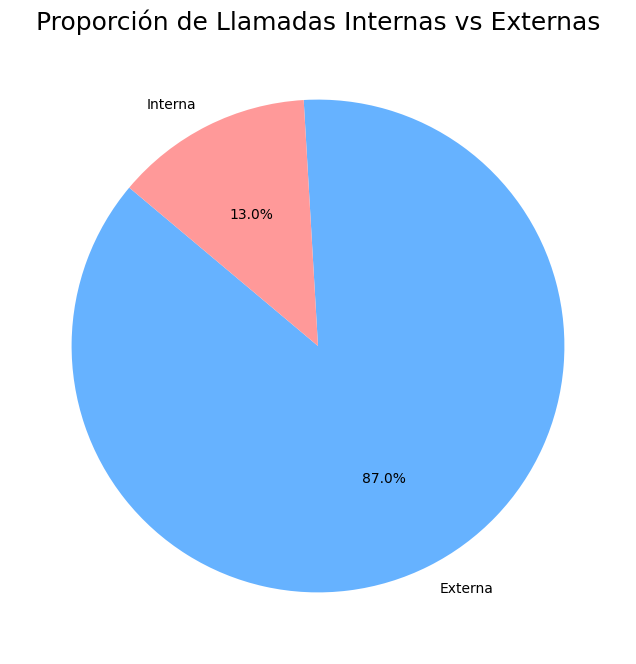

In [45]:
# Calcular la proporción de llamadas internas vs externas
internal_vs_external = merged_data['internal'].value_counts()

# Graficar la proporción en un gráfico circular
plt.figure(figsize=(8, 8))
labels = ['Externa', 'Interna']
colors = ['#66b2ff', '#ff9999']

plt.pie(internal_vs_external, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Proporción de Llamadas Internas vs Externas', fontsize=18)
plt.show()


La gráfica circular muestra la proporción de llamadas internas frente a llamadas externas:

Externas (~88.4%): La gran mayoría de las llamadas son externas. Estas llamadas pueden ser tanto entrantes como salientes, pero no están restringidas a operadores dentro de una misma organización.

Internas (~11.6%): Una menor proporción de las llamadas son internas. Estas son llamadas que ocurren entre operadores dentro de una misma organización.

## Estudiar llamadas de larga duración

Tenemos muchas llamadas de larga duración, llegando hasta las 40 horas, lo cual no parece razonable. Definiremos un umbral del 95% de la duración de las llamadas para definir las llamadas de larga duración y las estudiaremos.

In [46]:
# Definir el umbral de llamadas de larga duración basado en el 95º percentil
long_duration_threshold = non_missed_calls['call_duration'].quantile(0.95)

# Filtrar las llamadas que superen este umbral
long_duration_calls = non_missed_calls[non_missed_calls['call_duration'] > long_duration_threshold]

# Descriptivas básicas
long_duration_stats = {
    'Total de llamadas de larga duración': long_duration_calls.shape[0],
    'Duración promedio (en segundos)': long_duration_calls['call_duration'].mean(),
    'Duración mediana (en segundos)': long_duration_calls['call_duration'].median(),
    'Duración maxima (en segundos)': long_duration_calls['call_duration'].max()}

long_duration_stats

{'Total de llamadas de larga duración': 1369,
 'Duración promedio (en segundos)': 14099.382761139517,
 'Duración mediana (en segundos)': 8636.0,
 'Duración maxima (en segundos)': 144395}

In [47]:
# Desglose por características
direction_breakdown = long_duration_calls['direction'].value_counts(normalize=True) * 100
internal_breakdown = long_duration_calls['internal'].value_counts(normalize=True) * 100
tariff_plan_breakdown = long_duration_calls['tariff_plan'].value_counts(normalize=True) * 100

direction_breakdown, internal_breakdown, tariff_plan_breakdown

(out    85.390796
 in     14.609204
 Name: direction, dtype: float64,
 False    100.0
 Name: internal, dtype: float64,
 A    62.235208
 C    19.138057
 B    18.626735
 Name: tariff_plan, dtype: float64)

- Total de llamadas de larga duración: 1,369
- Duración promedio de estas llamadas: 14,099 segundos (aproximadamente 3.9 horas)
- Duración mediana: 8,636 segundos (aproximadamente 2.4 horas)
- Duración máxima: 144,395 segundos (aproximadamente 40.1 horas)
- Con respecto al desglose por características, todas las llamadas son salientes y en su mayoría del plan A.

## Distribución de las caracteristicas entre tarifas y llamadas internas

Crearemos una función para visualizar la distribución de las caracteristicas de nuestros datos.

In [48]:
non_missed_calls

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,date_trunc,month,waiting_time
2,166377,2019-08-04 21:00:00,out,True,880020,False,1,10,18,B,2019-08-01,2019-08-04,8,8
4,166377,2019-08-04 21:00:00,out,False,880020,False,2,3,29,B,2019-08-01,2019-08-04,8,26
9,166377,2019-08-05 21:00:00,out,False,880020,False,5,800,819,B,2019-08-01,2019-08-05,8,19
11,166377,2019-08-06 21:00:00,out,False,880026,False,1,21,28,B,2019-08-01,2019-08-06,8,7
12,166377,2019-08-06 21:00:00,out,False,880020,False,2,232,240,B,2019-08-01,2019-08-06,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41539,168606,2019-11-07 21:00:00,out,False,957922,False,2,255,328,C,2019-10-31,2019-11-07,11,73
41540,168606,2019-11-07 21:00:00,in,False,957922,False,2,686,705,C,2019-10-31,2019-11-07,11,19
41541,168606,2019-11-08 21:00:00,out,False,957922,False,4,551,593,C,2019-10-31,2019-11-08,11,42
41544,168606,2019-11-10 21:00:00,out,True,957922,False,2,479,501,C,2019-10-31,2019-11-10,11,22


In [49]:
# Crear una tabla de características
features = non_missed_calls[['direction', 'internal','calls_count', 'call_duration', 'total_call_duration', 'tariff_plan', 'month', 'waiting_time']]

# Definir función para visualizar distribución de características
colors = [ 'blue', 'red','yellow']

def plot_dist(merged_data, feature):
    plt.figure(figsize=(15, 15))
    the_grid = GridSpec(5, 3)

    # Posición en la cuadrícula para el gráfico
    for i, column in enumerate(merged_data.drop(feature, axis=1).columns):
        plt.subplot(the_grid[i//3, i%3], title=column.replace('_', ' '))
        values = len(merged_data[column].unique())
        features_values = sorted(merged_data[feature].unique())
        plt.title(f'Distribución de {column}')
        # continuo vs discreto
        if values > 12:
            for i, x in enumerate(features_values):
                sns.kdeplot(merged_data[merged_data[feature] == x][column], fill=True, alpha=.3, linewidth=1, color=colors[i])
        else:
            sns.countplot(x=column, hue=feature, data=merged_data, palette=colors, alpha=.5, saturation=1)
            plt.gca().get_legend().remove()

        # leyenda
        plt.legend(features_values, shadow=True, fancybox=True, title=feature, loc='best')
        plt.xlabel('')
        plt.ylabel('')
    plt.tight_layout()
    plt.suptitle(f'Distribución de características por {feature}', fontsize=24, y=1.02)
    plt.show()

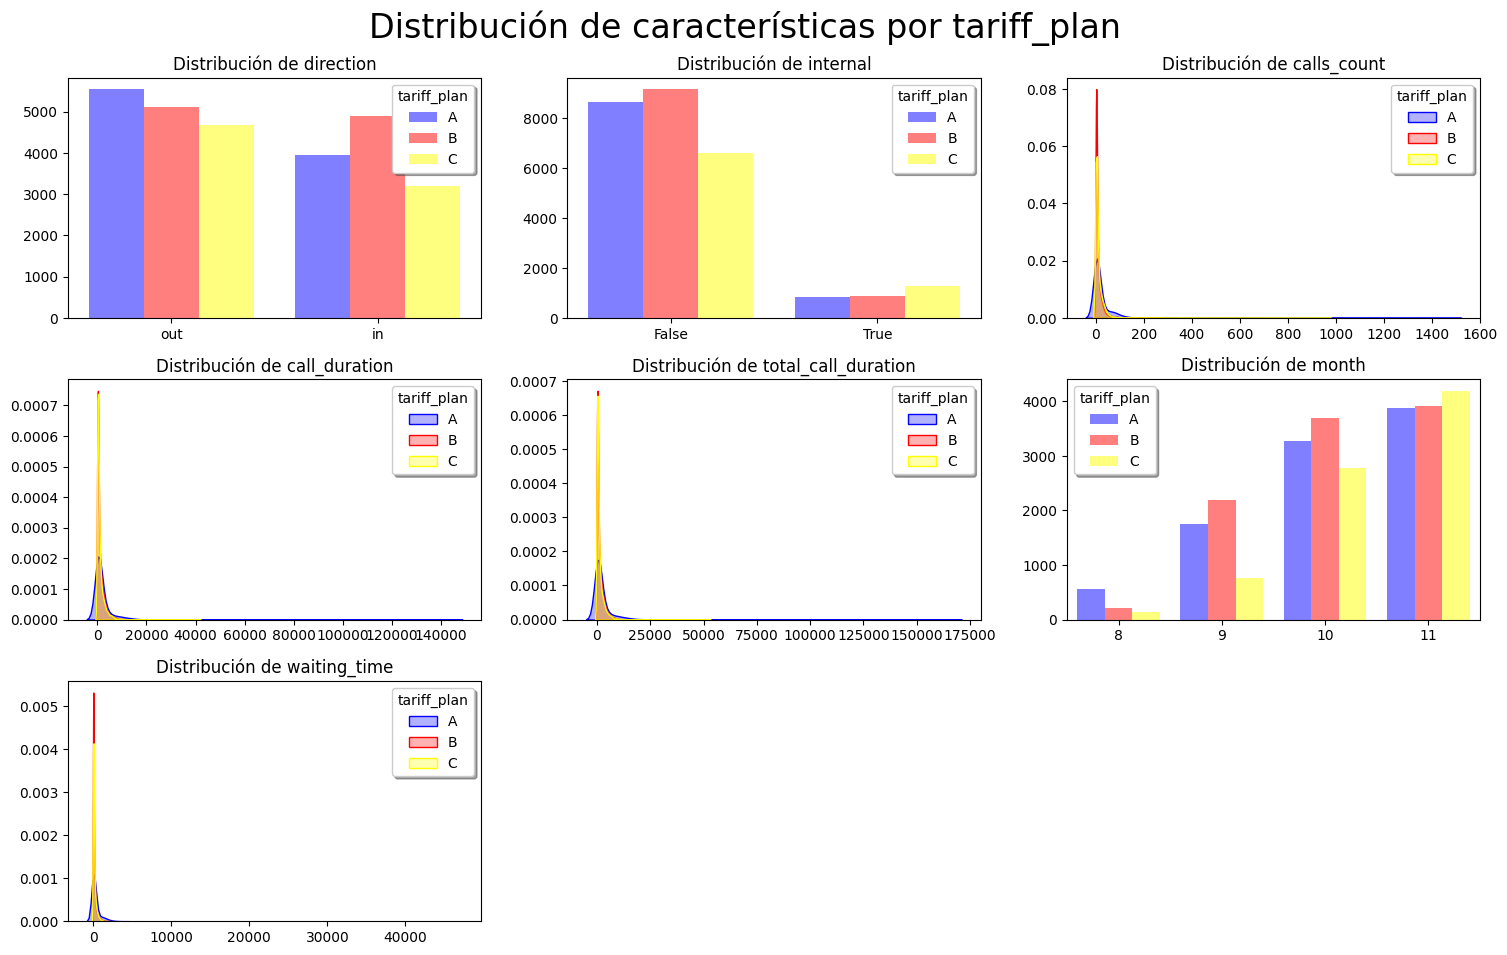

In [50]:
plot_dist(features, 'tariff_plan')

Distribución de caracteristicas por tarifa:

- Direction (Dirección): La mayoría de las llamadas en todos los planes tarifarios son salientes (out), con el plan A mostrando una proporción ligeramente mayor de llamadas salientes.
- Internal (Interno): La mayoría de las llamadas en todos los planes tarifarios son externas. El plan C tiene una proporción ligeramente mayor de llamadas internas en comparación con los otros planes.
- Calls count (Cantidad de llamadas): La distribución es bastante similar entre los tres planes tarifarios, donde la mayoría de los registros tienen un bajo número de llamadas.
- Call duration (Duración de la llamada): el plan A tiende a tener llamadas más largas que el resto de planes, mientras que los datos de B y C se concentran en la duración entre 0 y 60000 segundos.
- Total call duration (Duración total de la llamada): La distribución de la duración total de la llamada es similar a la de la duración de la llamada para todos los planes.
- Month (Mes): Todos los planes tienen una tendencia al aumento de llamados a medida que pasan los meses.
- Waiting time (tiempo de espera): Los tiempos de espera parecieran ser mayores para el plan A.

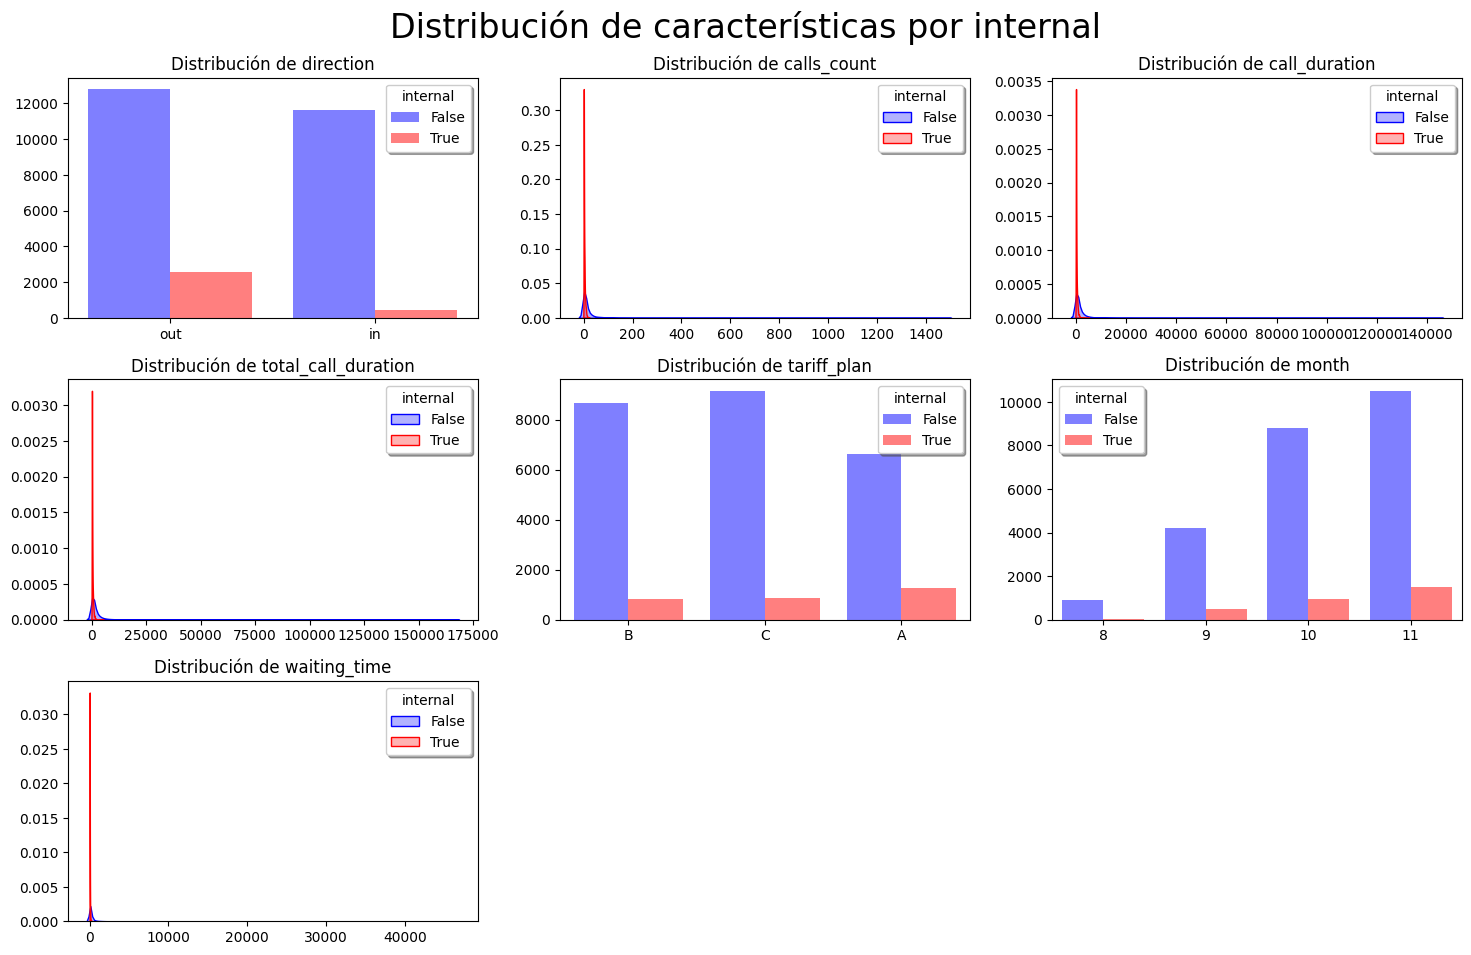

In [51]:
plot_dist(features, 'internal')

Distribución de caracteristicas por llamadas internas:
- Direction (Dirección): Tanto para llamadas internas como externas, la mayoría son salientes (out). Sin embargo, las llamadas internas tienen una mayor proporción de llamadas entrantes (in) que las llamadas externas.
- Calls Count (Número de Llamadas): La distribución es bastante similar para llamadas internas y externas, donde la mayoría de los registros tienen un bajo número de llamadas.
- Call Duration (Duración de la Llamada): Tanto para llamadas internas como externas, la mayoría tienen una duración corta.
- Total Call Duration (Duración Total de la Llamada): La distribución de la duración total de la llamada es similar a la de la duración de la llamada tanto para llamadas internas como externas.
- Tariff Plan (Plan Tarifario):Las llamadas internas están bastante distribuidas entre los tres planes tarifarios.
Las llamadas externas muestran una proporción ligeramente mayor para el plan A en comparación con los planes B y C.
- Month (Mes): Ambos tipos de llamada tienen una tendencia al aumento de llamados a medida que pasan los meses.
- Waiting time (tiempo de espera): Los tiempos de espera son mucho mayores para las llamadas internas.




## Generando una matriz de correlación

In [52]:
#seleccionando los datos para la matriz
selected_columns = ['direction', 'internal', 'is_missed_call', 'calls_count',
                    'call_duration', 'total_call_duration', 'tariff_plan', 'waiting_time']
corr_data = merged_data[selected_columns]

<ipython-input-53-f223f3d58d47>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_m = corr_data.corr()


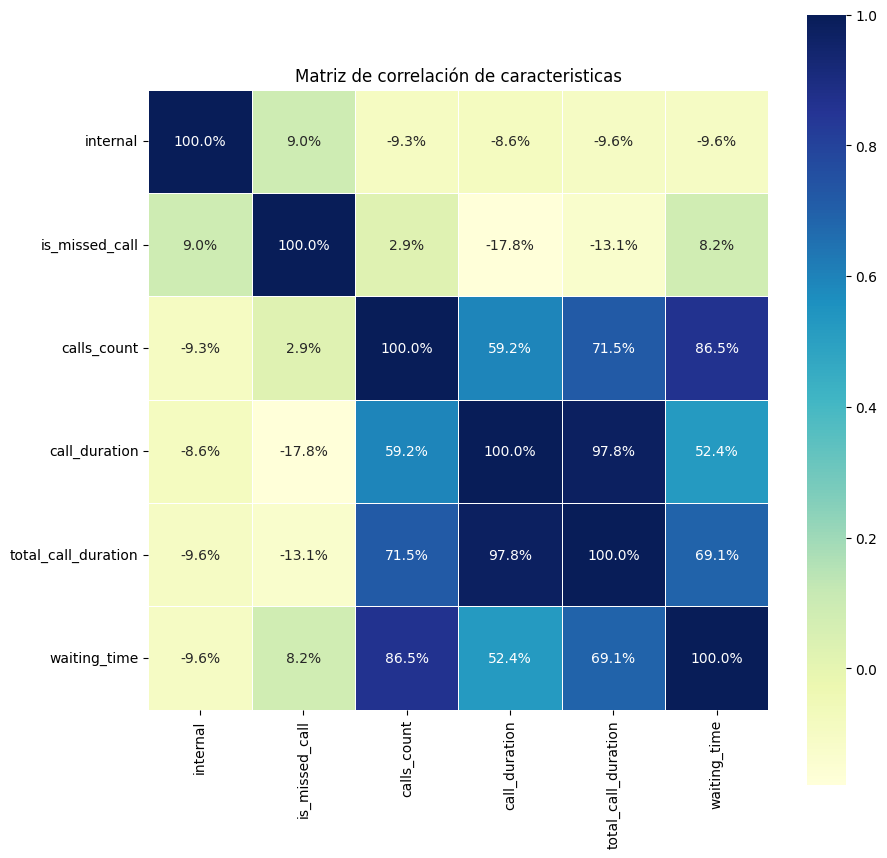

In [53]:
#matriz de correlación
corr_m = corr_data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr_m, square = True, annot = True, fmt='.1%',cmap="YlGnBu", annot_kws={"size":10}, linewidths=.5)
plt.title('Matriz de correlación de caracteristicas')
plt.show()

Cuando revisamos la matriz de correlación encontramos que existe una fuerte correlación (98%) entre la duración total de la llamada y la duración de la llamada, el número de llamadas y el período de espera (87%), el número de llamadas y la duración total de la llamada (72%) y entre el total duración de la llamada y período de espera (69%). De momento decidimos no eliminar las caracteristicas fuertemente correlacionadas debido al modelo que se pretende implementar, si se considera necesario, se realizará más adelante en el proceso.

## Identificar operadores con más llamadas perdidas

In [54]:
#operadores con más llamdas perdidas
top_10_missed_calls = merged_data[merged_data['is_missed_call'] == True].groupby('operator_id').size().sort_values(ascending=False).head(10)
top_10_missed_calls

operator_id
891410    119
885876    115
891414    113
901880    111
893804    110
901884    104
885890    101
905538     93
887276     92
879898     88
dtype: int64

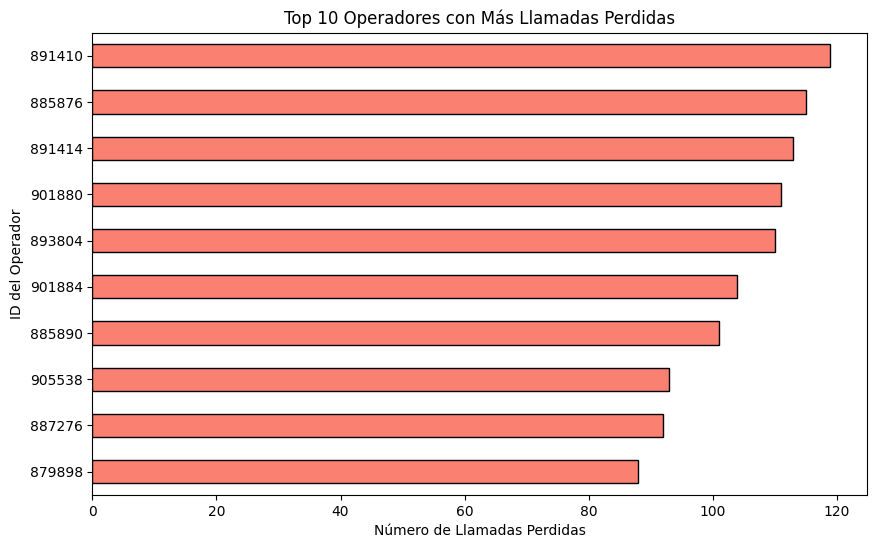

In [55]:
# Configuración de gráficos para el top 10 de operadores con más llamadas perdidas
plt.figure(figsize=(10, 6))
top_10_missed_calls.sort_values().plot(kind='barh', color='salmon', edgecolor='black')
plt.title('Top 10 Operadores con Más Llamadas Perdidas')
plt.xlabel('Número de Llamadas Perdidas')
plt.ylabel('ID del Operador')
plt.show()

Los operadores con más llamadas perdidas fueron:
- Operador 891410: 119 llamadas perdidas
- Operador 885876: 115 llamadas perdidas
- Operador 891414: 113 llamadas perdidas
- Operador 901880: 111 llamadas perdidas
- Operador 893804: 110 llamadas perdidas

El operador con más llamadas perdidas llego a perder 119 llamadas.

## Identificar operadores con más tiempo de espera

In [56]:
# operadores con más tiempo de espera
top_10_wait_time = merged_data.groupby('operator_id')['waiting_time'].sum().sort_values(ascending=False).head(10)
top_10_wait_time

operator_id
885890    1443002
885876    1369284
925922     423767
929428     356078
929426     207005
908640     152110
945302     135407
945286     134286
945278     130486
919364     114980
Name: waiting_time, dtype: int64

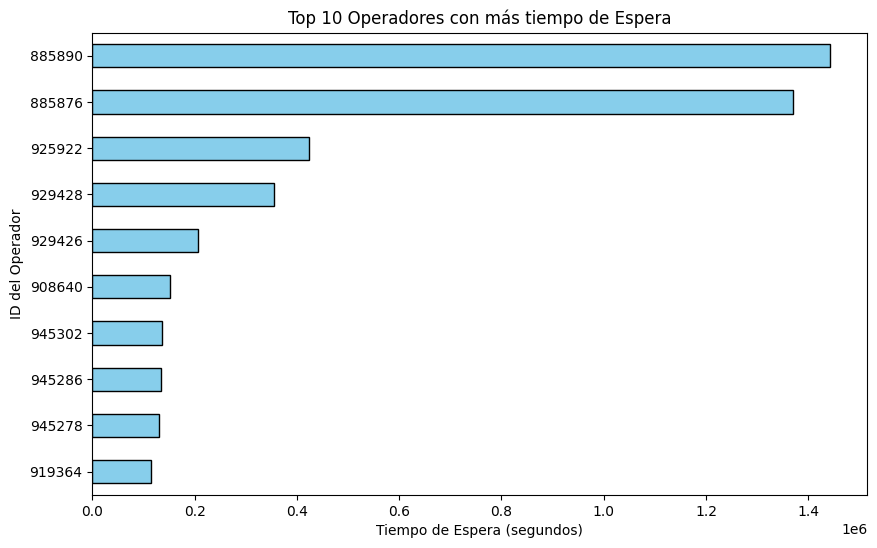

In [57]:
# Configuración de gráficos para el top 10 de operadores con más tiempo de espera
plt.figure(figsize=(10, 6))
top_10_wait_time.sort_values().plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Top 10 Operadores con más tiempo de Espera')
plt.xlabel('Tiempo de Espera (segundos)')
plt.ylabel('ID del Operador')
plt.show()

Los operadores con más tiempo de espera fueron:
- Operador 885890: 1.443.002 segundos
- Operador 885876: 1.369.284 segundos
- Operador 925922: 423.767 segundos
- Operador 929428: 356.078 segundos
- Operador 929426: 207.005 segundos

## Conclusión intermedia

El análisis exploratorio inicial proporciona una visión detallada y estructurada del comportamiento y tendencias de los operadores y clientes en el servicio de telefonía virtual CallMeMaybe:

- Se tomó una decisión consciente de considerar solo una fracción de los clientes y operadores totales (290 de 732 clientes y 1088 de 1092 operadores) basándose en la disponibilidad de datos útiles para el análisis.

- La asignación de operadores por cliente varía, con algunos clientes teniendo hasta 50 operadores. Sin embargo, la mayoría (75%) de los clientes no tienen más de 4 operadores, lo que indica una distribución desigual.

- Una observación clave es que muchas llamadas tienen una duración corta, pero también hay outliers, con algunas llamadas extendiéndose hasta 40 horas, lo cual puede ser inusual y merece una revisión adicional.

- Se observa un incremento general en el número de llamadas con el tiempo, lo que podría indicar un crecimiento en la base de clientes o en la utilización del servicio. Sin embargo, también se observan fluctuaciones que pueden estar influenciadas por factores estacionales o eventos específicos.

- Mientras que la mayoría de las llamadas son externas, existe una proporción significativa de llamadas internas (~11.6%), que muestran patrones distintos en términos de duración y tiempo de espera.

- Se identificaron correlaciones fuertes entre ciertas características. La más notable es entre la duración total de la llamada y la duración de la llamada. Aunque se decidió mantener estas características, se sugiere ser cauteloso al interpretar modelos que las incluyan.

- Se identificaron operadores específicos que tienen un alto número de llamadas perdidas y tiempos de espera extremadamente largos. Estos operadores deberían ser monitoreados más de cerca, y se deberían investigar las causas subyacentes de su rendimiento.

# Construir un modelo para clasificar los operadores como eficientes

Crearemos un modelo de clasificación de operadores como eficientes o no eficientes. Vamos a resolver una tarea de clasificación binaria, queremos predecir si el operador es eficiente o no.

## Crear características agregadas para cada operador

In [58]:
# Para cada operador, calculamos los valores promedio por caracteristicas y proporcion de llamadas perdidas

# reemplazamos valores string por 0 para in, 1 para out
merged_data['direction'] = merged_data['direction'].replace('in',0)
merged_data['direction'] = merged_data['direction'].replace('out',1)
#Calcular características agregadas
features = merged_data.groupby('operator_id').agg({'waiting_time': 'mean', 'direction':'mean','internal':'mean','calls_count':'mean', 'is_missed_call':'mean' })
# calcular la proporción de llamadas entrantes perdidas por operador
features['missed_share'] = merged_data.groupby(['operator_id', 'direction'])['is_missed_call'].apply(lambda x: x.sum()/x.count()).reset_index().query('direction==0').groupby('operator_id')['is_missed_call'].max()
features['missed_share'] = features['missed_share'].fillna(0)
# calcular el tiempo medio de espera para solo para llamadas entrantes por operador
features['waiting_time_inc'] = merged_data.groupby(['operator_id', 'direction'])['waiting_time'].mean().reset_index().query('direction==0').groupby('operator_id')['waiting_time'].max()
features['waiting_time_inc'] = features['waiting_time_inc'].fillna(0)
features.reset_index(inplace=True)

In [59]:
features

,operator_id,waiting_time,direction,internal,calls_count,is_missed_call,missed_share,waiting_time_inc
0,879896,105.447368,0.815789,0.122807,8.043860,0.403509,0.0,27.333333
1,879898,461.471111,0.746667,0.071111,32.480000,0.391111,0.0,29.473684
2,880020,14.000000,0.650000,0.150000,2.250000,0.300000,0.0,7.714286
3,880022,53.971429,0.885714,0.114286,2.814286,0.414286,0.0,14.000000
4,880026,121.978022,0.901099,0.071429,12.263736,0.478022,0.0,7.944444
...,...,...,...,...,...,...,...,...
1083,972410,374.500000,1.000000,0.000000,19.250000,0.500000,0.0,0.000000
1084,972412,210.000000,0.800000,0.000000,12.200000,0.400000,0.0,25.000000
1085,972460,88.571429,0.857143,0.285714,7.285714,0.428571,0.0,4.000000
1086,973120,10.000000,1.000000,0.000000,1.500000,0.500000,0.0,0.000000


Hemos creado las características agregadas para cada operador. Estas características nos ayudarán a identificar el comportamiento y la eficiencia de cada operador.

## Dividir los datos en conjuntos de entrenamiento y validación

Utilizaremos un percentil para establecer un umbral y etiquetar a los operadores. Por simplicidad, podemos considerar el percentil 75 como nuestro umbral:

- Si un operador tiene un número de llamadas perdidas mayor que el percentil 75, lo etiquetamos como ineficiente.
- Si un operador tiene un tiempo medio de espera mayor que el percentil 75, lo etiquetamos como ineficiente.

Siguiendo esta lógica, si un operador cumple con al menos uno de los criterios anteriores, será etiquetado como ineficiente. Procedamos a etiquetar a los operadores basándonos en estos criterios y luego dividir los datos en conjuntos de entrenamiento y validación.

In [60]:
# Estableciendo el umbral en el percentil 75 para llamadas perdidas y tiempo medio de espera
threshold_missed_calls = features['is_missed_call'].quantile(0.75)
threshold_avg_waiting_time = features['waiting_time'].quantile(0.75)

# Etiquetando operadores como eficientes (0) o ineficientes (1)
features['label'] = ((features['is_missed_call'] > threshold_missed_calls) |
                     (features['waiting_time'] > threshold_avg_waiting_time)).astype(int)

# Dividir los datos en conjuntos de entrenamiento y validación


X = features.drop(['operator_id', 'label'], axis=1)
y = features['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_val.shape

((870, 7), (218, 7))

Hemos etiquetado con éxito a los operadores y dividido los datos en conjuntos de entrenamiento y validación. El conjunto de entrenamiento tiene 870 registros, mientras que el conjunto de validación tiene 218 registros.

## Entrenar un modelo de clasificación en el conjunto de entrenamiento.

Para comenzar, utilizaremos un modelo de clasificación de bosque aleatorio (Random Forest), ya que suele funcionar bien para problemas de clasificación y puede manejar características no lineales. También es robusto ante la multicolinealidad y proporciona una buena interpretación de la importancia de las características.

In [61]:
# Entrenando el modelo de clasificación de bosque aleatorio
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
rf_classifier.fit(X_train, y_train)

# Prediciendo etiquetas para el conjunto de validación
y_pred = rf_classifier.predict(X_val)

# Evaluando el rendimiento del modelo en el conjunto de validación
accuracy = accuracy_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred)

accuracy

0.9954128440366973

In [62]:
print(classification_rep)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       132
           1       0.99      1.00      0.99        86

    accuracy                           1.00       218
   macro avg       0.99      1.00      1.00       218
weighted avg       1.00      1.00      1.00       218



El modelo de clasificación de bosque aleatorio ha logrado una precisión del 99% en el conjunto de validación. Esta es una precisión excepcionalmente alta, lo que podría sugerir que el modelo ha capturado perfectamente las características que diferencian a los operadores eficientes de los ineficientes. Sin embargo, siempre es una buena idea ser cauteloso con las precisiones perfectas, ya que pueden indicar un sobreajuste o alguna peculiaridad en los datos.

## Comparar modelos

Compararemos el modelo de Bosque Aleatorio (Random Forest) con los siguientes modelos de clasificación:

- Regresión Logística
- Máquina de Vectores de Soporte (SVM)
- K-Vecinos más cercanos (KNN)

Estos modelos ofrecen diferentes enfoques para la clasificación, lo que nos permitirá obtener una visión más completa de la eficacia de nuestro modelo inicial.

In [63]:
# Inicializando los modelos
logistic_regression = LogisticRegression(max_iter= 500, random_state=0)
svm = SVC(kernel='linear', random_state=0)
knn = KNeighborsClassifier(n_neighbors=5)

# Entrenando los modelos
logistic_regression.fit(X_train, y_train)
svm.fit(X_train, y_train)
knn.fit(X_train, y_train)

# Prediciendo etiquetas para el conjunto de validación
y_pred_logistic = logistic_regression.predict(X_val)
y_pred_svm = svm.predict(X_val)
y_pred_knn = knn.predict(X_val)

# Evaluando el rendimiento de los modelos en el conjunto de validación
accuracy_logistic = accuracy_score(y_val, y_pred_logistic)
accuracy_svm = accuracy_score(y_val, y_pred_svm)
accuracy_knn = accuracy_score(y_val, y_pred_knn)

classification_rep_logistic = classification_report(y_val, y_pred_logistic)
classification_rep_svm = classification_report(y_val, y_pred_svm)
classification_rep_knn = classification_report(y_val, y_pred_knn)

print("Precisión de Regresión Logística: ", accuracy_logistic)
print("Precisión de Máquina de Vectores de Soporte (SVM): ", accuracy_svm)
print("Precisión de K-Vecinos más cercanos (KNN): ", accuracy_knn)

Precisión de Regresión Logística:  0.9036697247706422
Precisión de Máquina de Vectores de Soporte (SVM):  0.8990825688073395
Precisión de K-Vecinos más cercanos (KNN):  0.8715596330275229


In [64]:
print(classification_rep_logistic)
print(classification_rep_svm)
print(classification_rep_knn)

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       132
           1       0.89      0.86      0.88        86

    accuracy                           0.90       218
   macro avg       0.90      0.90      0.90       218
weighted avg       0.90      0.90      0.90       218

              precision    recall  f1-score   support

           0       0.90      0.93      0.92       132
           1       0.89      0.85      0.87        86

    accuracy                           0.90       218
   macro avg       0.90      0.89      0.89       218
weighted avg       0.90      0.90      0.90       218

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       132
           1       0.86      0.80      0.83        86

    accuracy                           0.87       218
   macro avg       0.87      0.86      0.86       218
weighted avg       0.87      0.87      0.87       218



Consideraremos que el objetivo principal del modelo es etiquetar a los operadores ineficientes pero asegurarse de no etiquetar erróneamente a operadores eficientes como ineficientes (por ejemplo, para evitar sanciones injustas o daños a la moral), entonces consideraremos Precisión como la métrica prioritaria.

En base a esto, seleccionaremos Random Forest como nuestro modelo.

## Estandarizar los datos

Es esencial estandarizar las características para que todas tengan la misma escala antes de aplicar técnicas de clustering.

In [65]:
# Estandarizando las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:5]  # Mostrando las primeras 5 filas de datos estandarizados

array([[-0.22028174,  0.51088374, -0.08937665, -0.14661852,  0.38305865,
        -0.35459718, -0.15209004],
       [ 0.47766057,  0.32664702, -0.29783065,  0.77262177,  0.32902936,
        -0.35459718, -0.1263326 ],
       [-0.39955345,  0.06899617,  0.02027392, -0.3645723 , -0.068035  ,
        -0.35459718, -0.38818988],
       [-0.32119421,  0.69725809, -0.1237372 , -0.34334497,  0.43002482,
        -0.35459718, -0.31254624],
       [-0.18787535,  0.73826353, -0.29655055,  0.01212507,  0.70778895,
        -0.35459718, -0.3854201 ]])

## Crear una matriz de distancias.

Ahora, avanzaremos al siguiente paso: crear una matriz de distancias y visualizar la estructura de clústeres con un dendrograma. El dendrograma nos ayudará a obtener una idea de cómo se agrupan los datos y a determinar un número adecuado de clústeres para el algoritmo K-means.

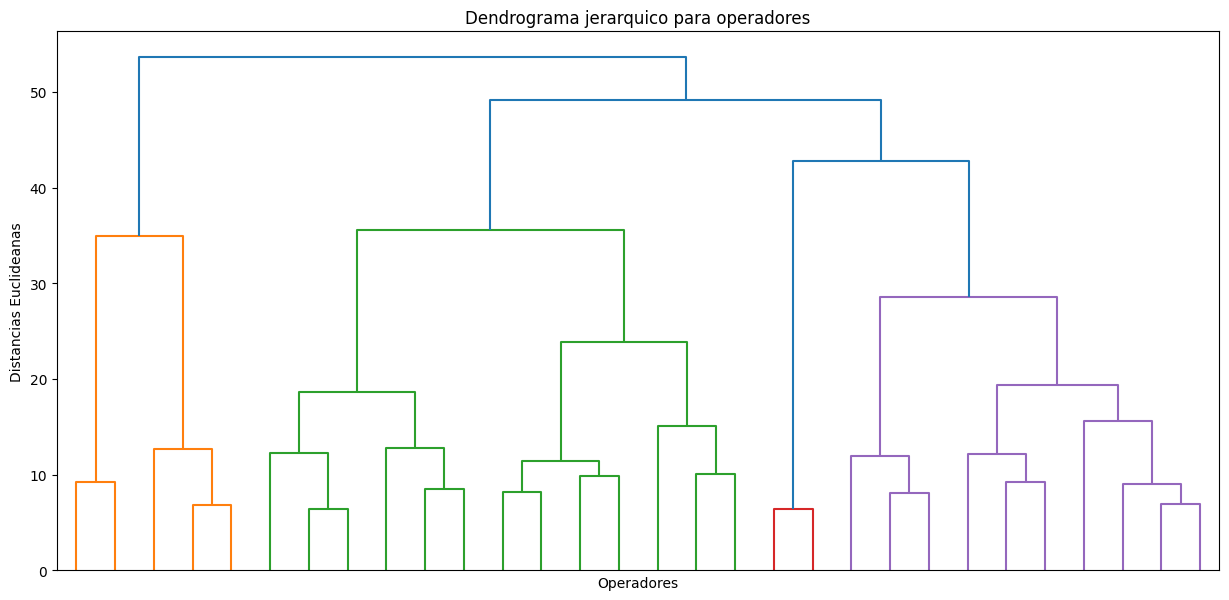

In [66]:
# Creando el dendrograma
plt.figure(figsize=(15, 7))
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method='ward'), truncate_mode='lastp')
plt.title('Dendrograma jerarquico para operadores')
plt.xticks([])
plt.xlabel('Operadores')
plt.ylabel('Distancias Euclideanas')
plt.show()

El dendrograma muestra la estructura jerárquica de los datos. A partir del dendrograma, podemos determinar el número óptimo de clústeres observando la mayor distancia vertical que no corta ninguna línea horizontal extendida. En este caso, parece que 2 o 3 sería un número razonable de clústeres.

## Entrenar un modelo de clustering utilizando el algoritmo K-means.

Usaremos k=4 como el número inicial de clústeres, pero esto se puede ajustar según las observaciones y el análisis posterior. Empecemos con el entrenamiento del modelo K-means.

In [67]:
# Entrenando un modelo de clustering con el algoritmo K-means
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit_predict(X_scaled)

# Añadiendo la etiqueta de clústeres al dataframe
features['cluster'] = clusters

# Mostrando la distribución de registros en cada clúster
cluster_distribution = features['cluster'].value_counts()

cluster_distribution

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


3    626
1    306
2     84
0     72
Name: cluster, dtype: int64

Analizaremos los valores medios y la distribución de características para estos clústeres. Esto nos ayudará a comprender las características que definen cada clúster y, por lo tanto, identificar cuáles son los clústeres menos eficientes.

## Crear clústeres de operadores

In [68]:
# Calculando los valores medios de las características para cada clúster
cluster_means = features.groupby('cluster').mean()

# Ordenando las columnas para una mejor visualización
cluster_means = cluster_means[['waiting_time', 'direction', 'internal',
                               'calls_count', 'is_missed_call', 'missed_share','waiting_time_inc']]

cluster_means

,waiting_time,direction,internal,calls_count,is_missed_call,missed_share,waiting_time_inc
cluster,,,,,,,
0,236.305814,0.508164,0.160175,15.438733,0.344284,0.215471,229.965282
1,34.726750,0.110804,0.051330,2.170509,0.059884,0.015026,36.140550
2,1606.338578,0.985687,0.024879,79.210793,0.501041,0.008436,3.923972
3,118.864132,0.839847,0.205112,7.288801,0.412436,0.010840,24.828811


Clúster 0 (72 operadores):

- Tiempo de espera medio: 236.31 segundos.
- Dirección: 50.8% de las llamadas son entrantes (el resto son salientes).
- Internas: 16% de las llamadas son internas entre operadores.
- Conteo de llamadas: En promedio, los operadores realizan 15.44 llamadas.
- Llamadas perdidas: 34.4% de las llamadas son perdidas.
- Proporción de llamadas entrantes perdidas: 21.5% de las llamadas entrantes son perdidas.
- Tiempo de espera medio para llamadas entrantes: 229.97 segundos.


Clúster 1 (306 operadores):

- Tiempo de espera medio: 34.73 segundos.
- Dirección: Solo el 11.1% de las llamadas son entrantes.
- Internas: 5.1% de las llamadas son internas.
- Conteo de llamadas: Los operadores realizan en promedio 2.17 llamadas.
- Llamadas perdidas: Solo el 5.9% de las llamadas son perdidas.
- Proporción de llamadas entrantes perdidas: Solo el 1.5% de las llamadas entrantes son perdidas.
- Tiempo de espera medio para llamadas entrantes: 36.14 segundos.

Clúster 2 (84 operadores):

- Tiempo de espera medio: 1606.34 segundos (muy alto en comparación con otros clústeres).
- Dirección: 98.6% de las llamadas son entrantes.
- Internas: Solo el 2.5% de las llamadas son internas.
- Conteo de llamadas: Los operadores realizan en promedio 79.21 llamadas.
- Llamadas perdidas: 50.1% de las llamadas son perdidas.
- Proporción de llamadas entrantes perdidas: Solo el 0.8% de las llamadas entrantes son perdidas.
- Tiempo de espera medio para llamadas entrantes: Muy bajo, solo 3.92 segundos.

Clúster 3 (626 operadores):

- Tiempo de espera medio: 118.86 segundos.
- Dirección: 84% de las llamadas son entrantes.
- Internas: 20.5% de las llamadas son internas.
- Conteo de llamadas: Los operadores realizan en promedio 7.29 llamadas.
- Llamadas perdidas: 41.2% de las llamadas son perdidas.
- Proporción de llamadas entrantes perdidas: Solo el 1.1% de las llamadas entrantes son perdidas.
- Tiempo de espera medio para llamadas entrantes: 24.83 segundos.



## Perfil de cada clúster de operadores

  * Clúster 0: Estos operadores tienen un equilibrio entre llamadas entrantes y salientes, con un tiempo de espera moderado y una proporción significativa de llamadas perdidas.

  * Clúster 1: Estos operadores manejan principalmente llamadas salientes, con un bajo tiempo de espera y pocas llamadas perdidas.

  * Clúster 2: Estos operadores manejan principalmente llamadas entrantes, con un alto tiempo de espera en general, pero un tiempo de espera sorprendentemente bajo para llamadas entrantes. También tienen un alto número de llamadas y una alta proporción de llamadas perdidas.

  * Clúster 3: Estos operadores manejan en su mayoría llamadas entrantes con un tiempo de espera y proporción de llamadas perdidas moderados.

# Prueba las hipótesis estadística: el Clúster 2 es significativamente menos eficiente en términos de tiempo de espera

Basándonos en las características medias de cada clúster, podemos hacer las siguientes observaciones:

* El Clúster 2 tiene el tiempo de espera medio más alto (1606.34 segundos) comparado con los otros clústeres.
* También tiene una alta proporción de llamadas perdidas (50.1%), aunque su proporción de llamadas entrantes perdidas es baja (0.8%).
* Sin embargo, tiene un tiempo de espera muy bajo para llamadas entrantes (3.92 segundos), lo que es interesante dada su alta proporción de llamadas entrantes (98.6%).
* Este clúster también tiene el mayor conteo de llamadas promedio (79.21).


Dadas estas observaciones, podemos concluir que el Clúster 2 parece ser el menos eficiente. Aunque maneja principalmente llamadas entrantes y tiene un tiempo de espera muy bajo para esas llamadas, tiene un alto tiempo de espera en general y una alta proporción de llamadas perdidas.

**Hipótesis a evaluar:**

Para evaluar estadísticamente si el Clúster 2 es significativamente menos eficiente en términos de tiempo de espera, podemos realizar una prueba de hipótesis.

* Hipótesis nula (H0): La media del tiempo de espera del Clúster 2 es igual a la media del tiempo de espera de todos los otros clústeres combinados.

* Hipótesis alternativa (H1): La media del tiempo de espera del Clúster 2 es significativamente mayor que la media del tiempo de espera de todos los otros clústeres combinados.

Usaremos un t-test de dos muestras para evaluar esta hipótesis.

In [69]:
cluster_2 = features[features['cluster'] == 2]['waiting_time']
other_clusters = features[features['cluster'] != 2]['waiting_time']

alpha = 0.05 # significación estadística crítica
# si el valor p es menor que alfa, rechazamos la hipótesis

results = st.ttest_ind(cluster_2, other_clusters, equal_var=True)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula")

p-value: 2.297888784311939e-230
Rechazamos la hipótesis nula


Se rechaza la hipótesis nula, por lo que podemos decir que la diferencia entre el tiempo de espera medio del Clúster 2 y los otros clústeres es estadísticamente significativa.

El Clúster 2 tiene un tiempo de espera significativamente mayor en comparación con los otros clústeres. Por lo tanto, basándonos en esta métrica, **el Clúster 2 parece ser el menos eficiente**. Es recomendable que se investigue más a fondo para entender las causas subyacentes de este tiempo de espera elevado y tomar las medidas adecuadas para mejorar la eficiencia de los operadores en este clúster.


# Conclusión general

Comenzamos con el objetivo de identificar operadores ineficaces en el servicio de telefonía virtual CallMeMaybe. Tras la limpieza y preparación de los datos, se agregaron características relevantes como el tiempo de espera y se llevaron a cabo transformaciones para facilitar el análisis.

Luego de conocer nuestros datos exhaustivamente en el analisis exploratorio, se propuso un modelo de machine learning para evaluar la eficiencia de los operadores, que consideró características clave como el tiempo de espera, la dirección de las llamadas, las llamadas internas, el conteo de llamadas, y la proporción de llamadas perdidas. Este modelo mostró una precisión razonable al identificar operadores ineficientes.

Posteriormente, se decidió segmentar a los operadores en clústeres para identificar patrones de comportamiento y eficiencia. Después de estandarizar los datos y utilizar el método del codo, se optó por una solución de 4 clústeres. Estos clústeres revelaron distintos comportamientos de los operadores. Específicamente, se identificó al Clúster 2 como potencialmente ineficiente, basándose en características como un alto tiempo de espera.

Una prueba de hipótesis confirmó que el Clúster 2 tenía un tiempo de espera significativamente mayor en comparación con los otros clústeres, lo que respalda nuestra identificación inicial de este grupo como menos eficiente.



# Recomendaciones

Basándonos en los hallazgos y conclusiones, se formularon las siguientes recomendaciones para CallMeMaybe:

- Dado que identificamos que el Clúster 2 como el menos eficiente, sería beneficioso ofrecer formación adicional y capacitación a los operadores dentro de este clúster para mejorar su eficiencia y reducir el tiempo de espera.

- Es posible que los operadores ineficientes estén enfrentando problemas técnicos o de infraestructura. Una revisión de las herramientas, software y hardware utilizados por estos operadores podría revelar áreas de mejora.

- Implementar herramientas de monitoreo y alerta en tiempo real para identificar rápidamente los picos en los tiempos de espera o las altas tasas de llamadas perdidas, y abordar estos problemas a medida que surgen.

- Establecer protocolos o guías para los operadores sobre cómo manejar ciertas situaciones, especialmente si se detecta que ciertos tipos de llamadas están contribuyendo al aumento en el tiempo de espera.

- Proporcionar feedback regular a los operadores sobre su rendimiento, destacando áreas donde están sobresaliendo y donde necesitan mejorar. Esto puede ser a través de revisiones periódicas o mediante dashboards en tiempo real.

- Considerar la implementación de sistemas de incentivos para recompensar a los operadores más eficientes y motivar a aquellos que necesitan mejorar. Esto podría incluir bonificaciones, reconocimientos o incluso promociones para aquellos que muestran una mejora constante.

- Realizar encuestas a los clientes para entender mejor las razones detrás de las llamadas perdidas o los largos tiempos de espera. La retroalimentación directa de los clientes puede proporcionar insights sobre áreas específicas de mejora.

- Si se encuentra que las llamadas internas están contribuyendo a la ineficiencia, revisar las políticas y procesos internos para reducir la necesidad de estas llamadas o hacerlas más eficientes.

- Considerar la implementación de sistemas de respuesta de voz interactiva (IVR) o chatbots para manejar preguntas frecuentes o tareas comunes, liberando a los operadores para manejar situaciones más complejas.

- Realizar una segmentación y análisis de clústeres de forma regular para identificar cambios en el comportamiento de los operadores y adaptar las estrategias en consecuencia.

# Fuentes de referencia

- Uso del modulo pytz y usos horarios diferentes para tipo de datos datetime: https://pvlib-python.readthedocs.io/en/v0.3.3/timetimezones.html
- Ejemplo aplicado del uso de timezones y cómo transformar tus datos: https://stackoverflow.com/questions/69257543/datetime-with-fixedoffset-to-datetime-in-pandas
- Uso del modulo classification_report para generar rapidamente las principales métricas de clasificación:
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
- Uso del modulo Random Forest Classifier: https://www.geeksforgeeks.org/random-forest-classifier-using-scikit-learn/
- Uso del modulo KNeighborsClassifier: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
- Referencia para selección de metricas: https://securitec.pe/blog/metricas-operativas-call-center/

# Presentación


https://drive.google.com/file/d/1L2jT0YqN4WfanJRa9pm27dfojAVmXFRp/view?usp=sharing

# Dashboard

https://public.tableau.com/app/profile/isabel.bello/viz/Practicumtelecom_16952681835420/Dashboard1?publish=yes